This notebook implements the algortihm proposed in:

Vanessa Gómez-Verdejo, Emilio Parrado-Hernández, Jussi Tohka and for the Alzheimer's Disease Neuroimaging Initiative, "Sign-consistency based voxel importance for machine learning in brain imaging". Submitt

** Create simulated data**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
def generate_data(N, Drel, Dirrel, sigma = 1):
    # Case 1: all data condense to 2 points
    # Case 2: completely separable, all variables are relevant
    # Case 3: completely separable, some irrelevant variables start to take role
    # Case 4: the irrelevant variables have same intensity as the 
    # Create labels
    Y = np.concatenate((np.ones((N/2,)),-1*np.ones((N/2,))), axis=0)

    # Relevant features
    Xrel = Y[:, np.newaxis] * np.ones((1,Drel)) + np.random.normal(0, sigma, (N, Drel))

    # Irrelevant features
    Xirrel = np.random.normal(0, sigma, (N, Dirrel))
    X = np.concatenate((Xrel,Xirrel), axis=1).T
    GT = np.concatenate((np.ones((Drel,)),np.zeros((Dirrel,))), axis=0)

    return X, Y, GT

In [3]:
# Number of data
Ndata = 200
Drel = 1000
Dirrel = 10000

X, Y, GT = generate_data(Ndata, Drel, Dirrel)

# Voxel importance with ensembles of linear SVMs

** Train an ensemble of bagged SVMs**

In [4]:
from sklearn.svm import SVC

num_bagging_iter = 10000
perc = 0.5
conformal_learning = False

def compute_bagging_clf(X, Y): 
    
    w_sign_tot = np.zeros((X.shape[0],))
    
    ntr = X.shape[1]
    pos_tr = np.arange(ntr)
    p_1 = np.where(Y == 1)[0]
    p_0 = np.where(Y == -1)[0]
    n_1 = p_1.shape[0]
    n_0 = p_0.shape[0]
       
    # Define the classifier to be used for the voxel selection
    K = np.dot(X.T,X)
    clf = SVC(C=100, kernel='precomputed')
 
    for i in range(num_bagging_iter):
        # Select training samples (at random) and balancing by clases
        np.random.seed(i)
        # In case of unbalanced problems, we balance the subsampling
        samples_sel_1 = np.random.permutation(p_1)[:int(np.round(0.5*perc*ntr))]
        samples_sel_0 = np.random.permutation(p_0)[:int(np.round(0.5*perc*ntr))]
        samples_sel = np.hstack((samples_sel_0, samples_sel_1))
        # Create a vector with the training positions
        pos_tr_sel = pos_tr[samples_sel]
       
        Y_sel =Y[pos_tr_sel]
        
        # Train the classifier
        clf.fit(K[pos_tr_sel[:, np.newaxis],pos_tr_sel], Y_sel) 
        w = np.dot(X[:,pos_tr_sel[clf.support_]],clf.dual_coef_.ravel())
       
        # Create a vector counting the number of positive weigths (indirectly we are also counting the negatives)
        w_sign = np.zeros(w.shape)
        w_sign [w>0] = 1
        # Add it to the total sum of positive weigths
        w_sign_tot = w_sign_tot + w_sign
    return w_sign_tot

In [6]:
nPositives = compute_bagging_clf(X, Y)

## Hypothesis test for selecting important voxels

In [7]:
N = num_bagging_iter
# Estimate the probability of being positive
hatp = nPositives/N

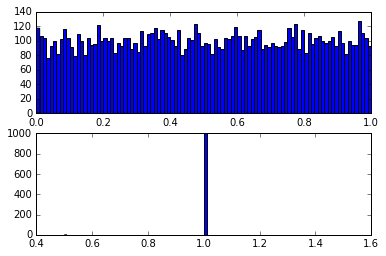

Distribution irrelevant voxels (upper) vs. relevant ones (lower)


In [8]:
# As it is a sythetic problem, we know the ground truth, let's plot the distributions over each sign
pos_GT1 = np.where(GT==1)[0]
pos_GT0 = np.where(GT==0)[0]

plt.figure(1)
plt.subplot(2,1,1)
plt.hist(hatp[pos_GT0],100)
plt.subplot(2,1,2)
plt.hist(hatp[pos_GT1],100)
plt.show()
print 'Distribution irrelevant voxels (upper) vs. relevant ones (lower)'

In [20]:
from scipy.stats import norm
def computeZTest(hatp, N, p0=0.5, gamma =0.5):
    s = ((1-gamma)/gamma)*hatp*(1-hatp)
    z = np.divide(hatp-p0, np.sqrt(s))
    p = norm.cdf(z)
    return z, p

In [21]:
z, p = computeZTest(hatp, N)

/usr/lib64/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in divide


Irrelevant voxels


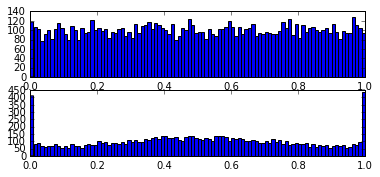

In [22]:
plt.figure(2)
plt.subplot(2,1,1)
plt.hist(hatp[pos_GT0],100)
plt.subplot(2,1,2)
plt.hist(p[pos_GT0],100)

print 'Irrelevant voxels'

Relevant voxels


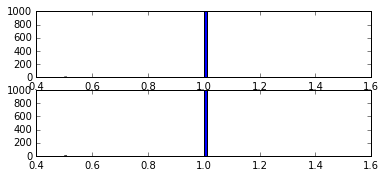

In [23]:
plt.figure(3)
plt.subplot(2,1,1)
plt.hist(hatp[pos_GT1],100)
plt.subplot(2,1,2)
plt.hist(p[pos_GT1],100)

print 'Relevant voxels'


**Voxel selection**

In [26]:
# Set the confidence level
alp = 0.05

print 'Irrelevant voxels selected:'
print np.where(np.any([p[pos_GT0]<0.5*alp, p[pos_GT0]>(1-0.5*alp)], axis=0))[0].shape[0]
print 'Total Irrelevant voxels:' + str(pos_GT0.shape[0]) 
print 'Relevant voxels selected:'
print np.where(np.any([p[pos_GT1]<0.5*alp, p[pos_GT1]>(1-0.5*alp)], axis=0))[0].shape[0]
print 'Total Relevant voxels:' + str(pos_GT1.shape[0]) 

Irrelevant voxels selected:
1107
Total Irrelevant voxels:10000
Relevant voxels selected:
1000
Total Relevant voxels:1000


# Transductive refinement of the voxel importance

**Create information for conformal analysis**

In [28]:
# Training data
Ndata = 200
Drel = 1000
Dirrel = 10000

X, Y, GT = generate_data(Ndata, Drel, Dirrel)

# Create test data
Ndata = 100
X_test, Y_test, GT_test = generate_data(Ndata, Drel, Dirrel)

pos_GT1 = np.where(GT==1)[0]
pos_GT0 = np.where(GT==0)[0]

In [29]:
import random

conformal_iterations = 50
n_data_test = X_test.shape[1]
# The number of conformal samples is set to 1% of the training data
n_data_conf = int(0.01* X.shape[1])
data = []
labels = []
for i in range(conformal_iterations):
    temp = []
    for j in range(n_data_conf):
        temp.append(random.choice([-1,1]))
    labels.append(temp)
    data.append(random.sample(range(n_data_test), n_data_conf))
conformal={}
conformal['data'] = np.array(data)
conformal['labels'] = np.array(labels)

** Train an ensemble of bagged SVMs with conformal analysis**

In [30]:
from sklearn.svm import SVC

num_bagging_iter = 10000
perc = 0.5

def compute_bagging_clf_conf(X, Y, X_test, n_conf): 
    
    w_sign_tot = np.zeros((X.shape[0],))
    
    ntr = X.shape[1]
    pos_tr = np.arange(ntr)
    p_1 = np.where(Y == 1)[0]
    p_0 = np.where(Y == -1)[0]
    n_1 = p_1.shape[0]
    n_0 = p_0.shape[0]
       
    Xall = np.hstack((X, X_test))
    K = np.dot(Xall.T,Xall)
    clf = SVC(C=100, kernel='precomputed')
        
    for i in range(num_bagging_iter):
        # Select training samples (at random) and balancing by clases
        np.random.seed(i)
        # In case of unbalanced problems, we balance the subsampling
        samples_sel_1 = np.random.permutation(p_1)[:int(np.round(0.5*perc*ntr))]
        samples_sel_0 = np.random.permutation(p_0)[:int(np.round(0.5*perc*ntr))]
        samples_sel = np.hstack((samples_sel_0, samples_sel_1))
        # Create a vector with the training positions
        pos_tr_sel = pos_tr[samples_sel]
       
        # For the conformal learning
        Y_sel = np.hstack((Y[pos_tr_sel], conformal['labels'][n_conf]))
        pos_tr_sel = np.hstack((pos_tr_sel, (ntr-1)+ conformal['data'][n_conf])).astype('int')
        
        # Train the classifier
        clf.fit(K[pos_tr_sel[:, np.newaxis],pos_tr_sel], Y_sel) 
        w = np.dot(Xall[:,pos_tr_sel[clf.support_]],clf.dual_coef_.ravel())
       
        # Create a vector counting the number of positive weigths (indirectly we are also counting the negatives)
        w_sign = np.zeros(w.shape)
        w_sign [w>0] = 1
        # Add it to the total sum of positive weigths
        w_sign_tot = w_sign_tot + w_sign
    return w_sign_tot

In [31]:
all_w_count = np.zeros((conformal_iterations, X.shape[0]))
for n_conf in range(10):#range(conformal_iterations):
    print n_conf
    all_w_count[n_conf,:] = compute_bagging_clf_conf(X, Y, X_test, n_conf)

0
1
2
3
4
5
6
7
8
9


**Voxel selection applying the conformal with the intersection of the selected subsets**

In [42]:
import copy

nPositives =all_w_count

N = num_bagging_iter
hatp = nPositives/N
z, p = computeZTest(hatp, N)

p1= np.where(p>0.5)
paux = copy.copy(p)
paux[p1] = 1-paux[p1]
# p<0.5 I get the maximum, and p>0.5 I get the minimum
pos = np.argmax(paux, axis=0)
p = np.array([pp[pos[i]] for i, pp in enumerate(p.T)])

/usr/lib64/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in divide


Irrelevant voxels selected:
37


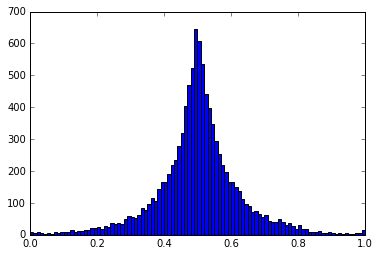

In [47]:
plt.figure(4)
plt.hist(p[pos_GT0],100)

alp = 0.05

print 'Irrelevant voxels selected:'
print  np.where(np.any([p[pos_GT0]<0.5*alp, p[pos_GT0]>(1-0.5*alp)], axis=0))[0].shape[0]

Relevant voxels
Relevant voxels selected:
997


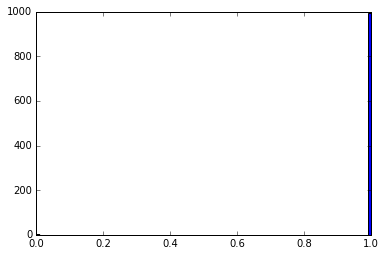

In [48]:
plt.figure(5)
plt.hist(p[pos_GT1],100)

print 'Relevant voxels'

alp = 0.05
print 'Relevant voxels selected:'
print np.where(np.any([p[pos_GT1]<0.5*alp, p[pos_GT1]>(1-0.5*alp)], axis=0))[0].shape[0]